In [1]:
# Imports
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import spacy 
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data processing

In [ ]:
load_dotenv()
filepath = os.getenv('FILEPATH')

In [ ]:

"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(100000000)


selected_columns = ["domain", "title", "authors", "type", "content", "url"]
sample_chunks = []
for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=100000, on_bad_lines='warn', engine='python'):
    sample = chunk.sample(frac=0.1, random_state=42)
    sample_chunks.append(sample)
    df = pd.concat(sample_chunks, ignore_index=True)

train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42) # 80% for training and temp for validation and testing
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42) # splitting the temp data into 10% for validation and 10% for testing

train_dataframe.to_csv("data/train_data.csv", chunksize=100000)
validation_dataframe.to_csv("data/validation_data.csv", chunksize=100000)
test_dataframe.to_csv("data/test_data.csv", chunksize=100000)

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()
csv.field_size_limit(100000000)

# I used chatgpt here for understanding how to use spacy and processing the texts in batches
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopwword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

input_files = ["data/train_data.csv", "data/validation_data.csv", "data/test_data.csv"]
output_files = ["data/processed_train.csv", "data/processed_validation.csv", "data/processed_test.csv"]

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["label"] = chunk["type"].apply(lambda x: 1 if str(x).strip().lower() == "reliable" else 0)
            # collecting yields into a list
            texts = chunk["content"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "label", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing data/train_data.csv
Chunk processed in 41.68s
Chunk processed in 36.66s
Chunk processed in 33.15s
Chunk processed in 29.37s
Chunk processed in 32.15s
Chunk processed in 35.13s
Chunk processed in 34.38s
Chunk processed in 34.46s
Chunk processed in 33.31s
Chunk processed in 33.41s
Chunk processed in 37.71s
Chunk processed in 32.55s
Chunk processed in 35.11s
Chunk processed in 33.88s
Chunk processed in 34.62s
Chunk processed in 31.81s
Chunk processed in 33.06s
Chunk processed in 33.60s
Chunk processed in 35.59s
Chunk processed in 35.02s
Chunk processed in 35.27s
Chunk processed in 34.12s
Chunk processed in 34.75s
Chunk processed in 36.72s
Chunk processed in 36.26s
Chunk processed in 34.21s
Chunk processed in 36.62s
Chunk processed in 33.07s
Chunk processed in 34.77s
Chunk processed in 36.04s
Chunk processed in 36.39s
Chunk processed in 33.67s
Chunk processed in 36.88s
Chunk processed in 35.63s
Chunk processed in 34.49s
Chunk processed in 34.91s
Chunk processed in 36.76s
Chunk p

In [11]:
df_train = pd.read_csv("data/processed/processed_train.csv")  
df_valid = pd.read_csv("data/processed/processed_validation.csv")
df_test = pd.read_csv("data/processed/processed_test.csv")  

### Computing reduction rates

In [11]:

stats_path = "data/preprocessing_stats.txt"

if os.path.exists(stats_path):
    print("Preprocessing stats already exist, reading from file\n")
    with open(stats_path, "r", encoding="utf-8") as f:
        print(f.read())
else: 
    original_vocab_size = len(original_vocab) 
    filtered_vocab_size = len(filtered_vocab_counter)
    lemmatized_vocab_size = len(lemmatized_vocab_counter)

    # reduction rate after stopword removal
    stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

    # calculating elmamtized reduction rate
    lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

    print(f"Original vocabulary size: {original_vocab_size}")
    print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
    print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
    print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
    print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

    with open("data/preprocessing_stats.txt", "w", encoding="utf-8") as f:
        f.write(f"Original vocabulary size: {original_vocab_size}\n")
        f.write(f"Vocabulary size after removing stopwords: {filtered_vocab_size}\n")
        f.write(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}\n")
        f.write(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%\n")
        f.write(f"Lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%\n")

    print(df_train.head()) 



Original vocabulary size: 1107067
Vocabulary size after removing stopwords: 1106762
Vocabulary size after lemmatization: 1085243
Stopword reduction rate: 0.03%
lemmatized reduction rate: 1.94%
                                      processed_text  label       type  \
0  times cover widely regard major american fashi...      1   reliable   
1  dear reader excited announce voice russia chan...      0       bias   
2     late deliver daily friend think read newspaper      0  political   
3  receive natural health newsletter free subscri...      0    junksci   
4  break tradition budget year yes go deliver fal...      0     satire   

            domain                                              title  \
0      nytimes.com  Gösta Peterson, Barrier-Breaking Fashion Photo...   
1  sputniknews.com  austerity, 2013 : The Voice of Russia: News, B...   
2      pjmedia.com  'Hell or High Water' Is A Pro-Second Amendment...   
3  naturalnews.com  antidepressants articles and information on th... 

### Exploring train data (task 2)

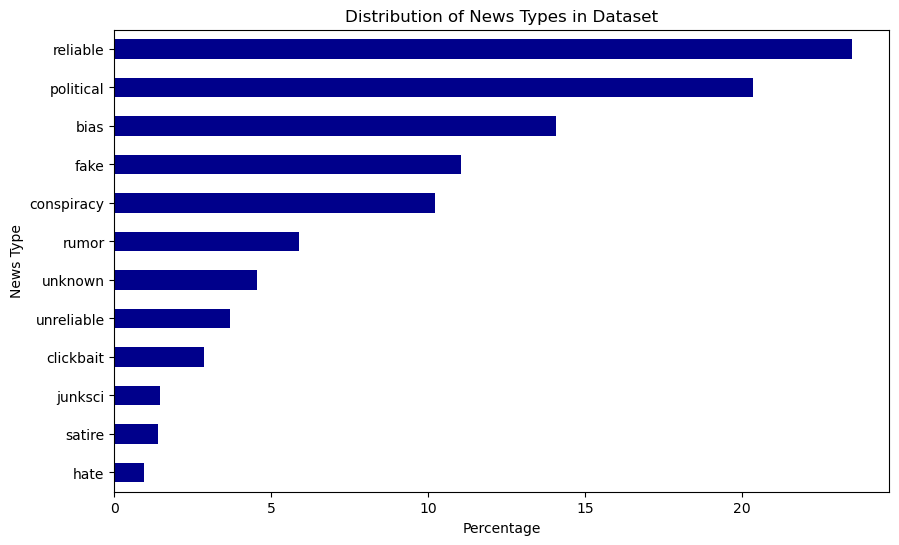

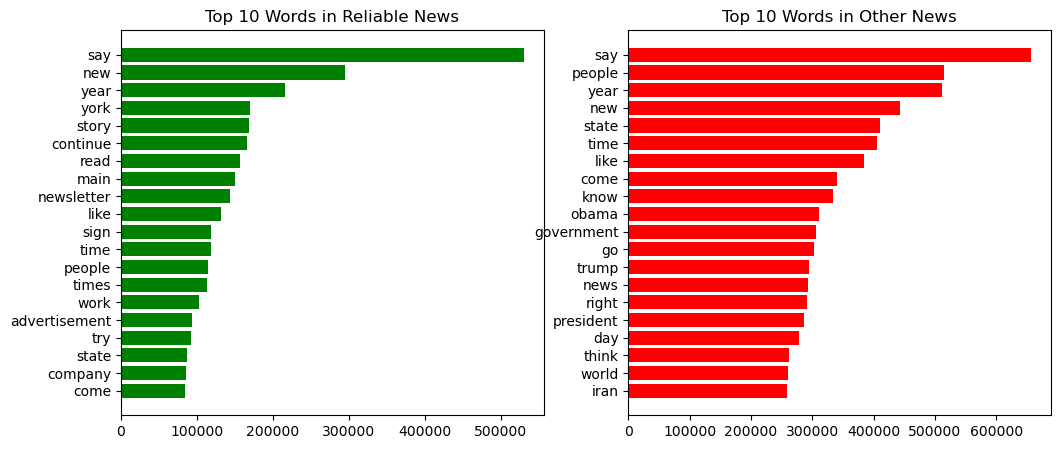

In [12]:
   
# Precentage distribution of labels in the datasetr
type_distribution = df_train["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

# visualizing the distribution of words in reliable vs non-reliable news
reliable_texts = df_train[df_train["label"] == 1]["processed_text"].dropna().astype(str)
other_texts = df_train[df_train["label"] != 1]["processed_text"].dropna().astype(str)

reliable_counter = Counter(" ".join(reliable_texts).split())
other_counter = Counter(" ".join(other_texts).split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(20)
other_top10 = other_counter.most_common(20)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()

# Avanced model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import pickle

### Training the LSTM model

In [ ]:

MAX_WORDS=10000
MAX_LEN=100
LSTM_UNITS=64
NUM_CLASSES=1 # 1 class bc its binary classification

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

In [ ]:
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

model = load_model("models/advanced_model.keras")


In [ ]:
x_train = df_train["processed_text"].fillna("").astype(str).tolist()
y_train = df_train["label"].values

# reference: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

# padding sequences make all sequences the same length
xTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')



In [15]:
# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 32))
model.add(LSTM(LSTM_UNITS))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [16]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# training the model
model.fit(xTrain, y_train, batch_size=32, epochs=10)

Epoch 1/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 493s 23ms/step - accuracy: 0.8872 - loss: 0.2818
Epoch 2/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 512s 24ms/step - accuracy: 0.9486 - loss: 0.1334
Epoch 3/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 514s 24ms/step - accuracy: 0.9576 - loss: 0.1103
Epoch 4/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 533s 25ms/step - accuracy: 0.9643 - loss: 0.0940
Epoch 5/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 494s 23ms/step - accuracy: 0.9696 - loss: 0.0811
Epoch 6/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 515s 24ms/step - accuracy: 0.9750 - loss: 0.0674
Epoch 7/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 510s 24ms/step - accuracy: 0.9799 - loss: 0.0558
Epoch 8/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 521s 24ms/step - accuracy: 0.9840 - loss: 0.0454
Epoch 9/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 492s 23ms/step - accuracy: 0.9874 - loss: 0.0372
Epoch 10/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 505s 24ms/step - accuracy: 0.9898 - loss: 0.0305


In [ ]:
model.save("models/advanced_model.keras")  # saving model for later use

### Validating

In [22]:
x_valid = df_test["processed_text"].fillna("").astype(str).tolist()
y_valid = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_valid)
# padding sequences make all sequences the same length
xValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xValid)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_valid, y_pred))

print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1-score:", f1_score(y_valid, y_pred))


2666/2666 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     66171
           1       0.90      0.84      0.87     19120

    accuracy                           0.94     85291
   macro avg       0.93      0.90      0.91     85291
weighted avg       0.94      0.94      0.94     85291

Accuracy: 0.941998569602889
Precision: 0.8980061780398765
Recall: 0.8362447698744769
F1-score: 0.8660257278266756


### Evaluating the model

In [23]:
x_test = df_test["processed_text"].fillna("").astype(str).tolist()
y_test = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_test)

# padding sequences make all sequences the same length
xTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xTest)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

loss, accuracy = model.evaluate(xTest, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     66171
           1       0.90      0.84      0.87     19120

    accuracy                           0.94     85291
   macro avg       0.93      0.90      0.91     85291
weighted avg       0.94      0.94      0.94     85291

Accuracy: 0.941998569602889
Precision: 0.8980061780398765
Recall: 0.8362447698744769
F1-score: 0.8660257278266756
2666/2666 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9414 - loss: 0.2288
Test Loss: 0.2237
Test Accuracy: 0.9420


# Liar test

In [5]:
liar_test_filepath = "data/liar/test.tsv"
liar_valid_filepath = "data/liar/valid.tsv"
 
# convert liar data to csv
# liar headers
liar_headers= ["id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
                "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"]
# convert liar data to csv
liar_test_df = pd.read_csv(liar_test_filepath, sep="\t", header=None, names=liar_headers)
liar_valid_df = pd.read_csv(liar_valid_filepath, sep="\t", header=None, names=liar_headers)
 
liar_test_df.to_csv("data/liar/test.csv", index=False)
liar_valid_df.to_csv("data/liar/valid.csv", index=False)
 
# labels in liar = true, false, half-true, pants-fire, barely-true, mostly-true
# only true and mostly-true are true others are false
# converting labels to binary 1=true, 0=false
liar_selected_columns = ["label", "subject", "statement"]
 
input_files = ["data/liar/test.csv", "data/liar/valid.csv"]
output_files = ["data/liar/test_processed.csv", "data/liar/valid_processed.csv"]

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
def preprocess_liar(text):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=liar_selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["bin_label"] = chunk["label"].apply(lambda x: 1 if str(x).strip().lower() in ["true", "mostly-true"] else 0)
            # collecting yields into a list
            texts = chunk["statement"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess_liar(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "bin_label", "subject", "label"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing data/liar/test.csv
Chunk processed in 9.32s
Chunk processed in 8.21s
Processing data/liar/valid.csv
Chunk processed in 10.58s
Chunk processed in 8.86s
Preprocessing done.


In [7]:
df_valid_liar = pd.read_csv("data/liar/valid_processed.csv")  
df_test_liar = pd.read_csv("data/liar/test_processed.csv") 

### Valid data from liar

In [20]:
x_liar_valid = df_valid_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_valid = df_valid_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_valid)

# padding sequences make all sequences the same length
xLiarValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_valid = model.predict(xLiarValid)
y_pred_valid = (y_pred_probs_valid >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_valid, y_pred_valid))

loss, accuracy = model.evaluate(xLiarValid, y_liar_valid)
print(f"LIAR Test Loss: {loss:.4f}")
print(f"LIAR Test Accuracy: {accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       864
           1       0.41      0.05      0.08       420

    accuracy                           0.67      1284
   macro avg       0.54      0.51      0.44      1284
weighted avg       0.59      0.67      0.56      1284

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6781 - loss: 1.9906
LIAR Test Loss: 2.1091
LIAR Test Accuracy: 0.6667


### Test data from liar

In [21]:
x_liar_test = df_test_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_test = df_test_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_test)

# padding sequences make all sequences the same length
xLiarTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_test = model.predict(xLiarTest)
y_pred_test = (y_pred_probs_test >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_test, y_pred_test))

loss, accuracy = model.evaluate(xLiarTest, y_liar_test)
print(f"LIAR Test Loss: {loss:.4f}")
print(f"LIAR Test Accuracy: {accuracy:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.65      0.98      0.78       818
           1       0.53      0.05      0.09       449

    accuracy                           0.65      1267
   macro avg       0.59      0.51      0.44      1267
weighted avg       0.61      0.65      0.54      1267

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6592 - loss: 2.2472
LIAR Test Loss: 2.2910
LIAR Test Accuracy: 0.6480
